# Import libs 

In [1]:
# Install libs
!pip install -qq peft==0.6.0
!pip install -qq bitsandbytes==0.41.1
!pip install -qq accelerate==0.24.1
!pip install -qq transformers==4.35.0
!pip install -qq torch~=2.1.0 --index-url https://download.pytorch.org/whl/cpu -q 
!pip install -qq torch_xla[tpu]~=2.1.0 -f https://storage.googleapis.com/libtpu-releases/index.html -q
!pip uninstall -qq tensorflow -y
!cp /kaggle/input/utils-xla/spmd_util.py 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
diffusers 0.28.0 requires huggingface-hub>=0.20.2, but you have huggingface-hub 0.17.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.18.0 requires torch==2.3.0, but you have torch 2.1.2+cpu which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 2.1.2+cpu which is incompatible.
torchaudio 2.3.0 requires torch==2.3.0, but you have torch 2.1.2+cpu which is incompatible.


In [2]:
import os
import gc
import re
from time import time
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import transformers
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, LlamaModel, LlamaForSequenceClassification
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import torch.nn.functional as F

import torch_xla.debug.profiler as xp
import torch_xla.core.xla_model as xm
import torch_xla.experimental.xla_sharding as xs
import torch_xla.runtime as xr

xr.use_spmd()

from torch_xla.experimental.xla_sharded_tensor import XLAShardedTensor
from torch_xla.experimental.xla_sharding import Mesh
from spmd_util import partition_module

tqdm.pandas()

print(f'Torch Version: {torch.__version__}')

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/usr/local/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
Torch Version: 2.1.2+cpu


# Configs

In [3]:
class CFG:
    NUM_EPOCHS = 2
    BATCH_SIZE = 8
    DROPOUT = 0.05 
    MODEL_NAME = '/kaggle/input/llama-3/transformers/8b-chat-hf/1'
    SEED = 2024 
    MAX_LENGTH = 1080 
    NUM_WARMUP_STEPS = 128
    LR_MAX = 5e-5 
    NUM_LABELS = 3 
    LORA_RANK = 4
    LORA_ALPHA = 8
    LORA_MODULES = ['o_proj', 'v_proj']
    
DEVICE = xm.xla_device() # Initialize TPU Device

In [4]:
def set_seeds(seed):
    """Set seeds for reproducibility """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    # Set seed for all TPU cores
    xm.set_rng_state(seed, device=xm.xla_device())  

set_seeds(seed=CFG.SEED)

# Tokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'
tokenizer.add_eos_token = True

# save tokenizer to load offline during inference
tokenizer.save_pretrained('tokenizer')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/tokenizer.json')

In [6]:
# Utility function giving token length
def get_token_lengths(texts):
    # tokenize and receive input_ids for reach text
    input_ids = tokenizer(texts.tolist(), return_tensors='np')['input_ids']
    # return length of inputs_ids for each text
    return [len(t) for t in input_ids]

# Prepare train


In [7]:
train = pd.read_csv('/kaggle/input/lmsys-chatbot-arena/train.csv')
def process(input_str):
    stripped_str = input_str.strip('[]')
    sentences = [s.strip('"') for s in stripped_str.split('","')]
    return  ' '.join(sentences)

train.loc[:, 'prompt'] = train['prompt'].apply(process)
train.loc[:, 'response_a'] = train['response_a'].apply(process)
train.loc[:, 'response_b'] = train['response_b'].apply(process)

# Drop 'Null' for training
indexes = train[(train.response_a == 'null') & (train.response_b == 'null')].index
train.drop(indexes, inplace=True)
train.reset_index(inplace=True, drop=True)

print(f"Total {len(indexes)} Null response rows dropped")
print('Total train samples: ', len(train))

Total 19 Null response rows dropped
Total train samples:  57458


In [ ]:
train.head(5)

In [8]:
train['text'] = 'User prompt: ' + train['prompt'] +  '\n\nModel A :\n' + train['response_a'] +'\n\n--------\n\nModel B:\n'  + train['response_b']
print(train['text'][4])

User prompt: What is the best way to travel from Tel-Aviv to Jerusalem? Car? Bus? Plane?

Model A :
The best way to travel from Tel Aviv to Jerusalem depends on your personal preference and the availability of transportation options. All the options you have mentioned are valid options, but here are some details to help you make your decision:\n\n*   By car: Traveling by car is the quickest way to get from Tel Aviv to Jerusalem, as the distance between the two cities is only about 60 kilometers (37 miles). It takes around 45 minutes to drive from Tel Aviv to Jerusalem by car, depending on the traffic.\n*   By bus: There are several bus lines that run from Tel Aviv to Jerusalem, and the journey takes around 1 hour and 30 minutes by bus. The buses are comfortable and reliable, and they offer a scenic view of the beautiful Israeli countryside.\n*   By plane: There are no direct flights from Tel Aviv to Jerusalem, so you need to take a flight from Tel Aviv's Ben Gurion International Airpor

In [9]:
# Train with only take 50% train dataset
train = train[:int(len(train) * 0.5)]

train.loc[:, 'token_count'] = get_token_lengths(train['text'])

# prepare label for model
train.loc[:, 'label'] = np.argmax(train[['winner_model_a','winner_model_b','winner_tie']].values, axis=1)

# Display data
display(train.head())

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,text,token_count,label
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,User prompt: Is it morally right to try to hav...,1205,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,User prompt: What is the difference between ma...,1392,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1,User prompt: explain function calling. how wou...,663,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0,User prompt: How can I create a test set for a...,1007,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0,User prompt: What is the best way to travel fr...,478,1


In [10]:
# token Count
display(train['token_count'].describe().to_frame().astype(int))

,token_count
count,28729
mean,728
std,768
min,17
25%,287
50%,562
75%,899
max,15427


<Axes: >

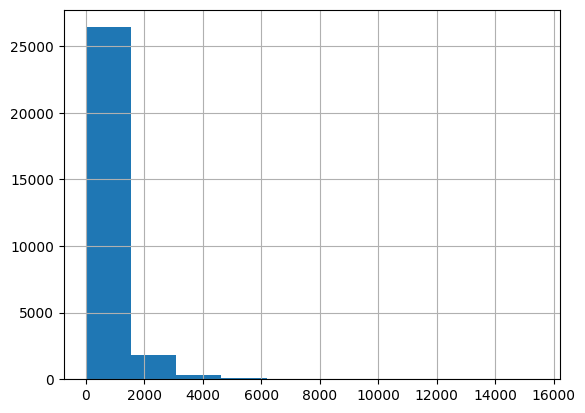

In [12]:
train['token_count'].hist()

In [11]:
# get length of tokens which covers 90% of data, we'll still take 1024 length!
np.percentile(train['token_count'], 90)

1398.2000000000007

# Tokenize

In [13]:
# Tokenize Data
tokens = tokenizer(
    train['text'].tolist(), 
    padding='max_length', 
    max_length=CFG.MAX_LENGTH, 
    truncation=True, 
    return_tensors='np')

# Input IDs are the token IDs
INPUT_IDS = tokens['input_ids']
# Attention Masks to Ignore Padding Tokens
ATTENTION_MASKS = tokens['attention_mask']
# Label of Texts
LABELS = train[['winner_model_a','winner_model_b','winner_tie']].values

print(f'INPUT_IDS shape: {INPUT_IDS.shape}, ATTENTION_MASKS shape: {ATTENTION_MASKS.shape}')
print(f'LABELS shape: {LABELS.shape}')

INPUT_IDS shape: (28729, 1080), ATTENTION_MASKS shape: (28729, 1080)
LABELS shape: (28729, 3)


In [14]:
def train_dataset(batch_size):
    N_SAMPLES = LABELS.shape[0]
    IDXS = np.arange(N_SAMPLES - (N_SAMPLES % batch_size))
    while True:
        # Shuffle Indices
        np.random.shuffle(IDXS)
        # Iterate Over All Indices Once
        for idxs in IDXS.reshape(-1, batch_size):
            input_ids = torch.tensor(INPUT_IDS[idxs]).to(DEVICE)
            attention_mask = torch.tensor(ATTENTION_MASKS[idxs]).to(DEVICE)
            labels = torch.tensor(LABELS[idxs]).to(DEVICE)  # Multi-label output
            
            xs.mark_sharding(input_ids, mesh, (0, 1))
            xs.mark_sharding(attention_mask, mesh, (0, 1))
            xs.mark_sharding(labels, mesh, (0, 1))
            
            yield input_ids, attention_mask, labels

TRAIN_DATASET = train_dataset(CFG.BATCH_SIZE)

# Load Model

In [15]:
# Load model for classification with 3 target label
base_model = LlamaForSequenceClassification.from_pretrained(
    CFG.MODEL_NAME,
    num_labels=CFG.NUM_LABELS,
    torch_dtype=torch.bfloat16)

base_model.config.pretraining_tp = 1 

# Assign Padding TOKEN
base_model.config.pad_token_id = tokenizer.pad_token_id

Loading checkpoint shards: 100%|██████████| 4/4 [00:20<00:00,  5.13s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/llama-3/transformers/8b-chat-hf/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Low-Rank Adaptation [LORA]

In [16]:
lora_config = LoraConfig(
    r=CFG.LORA_RANK,  # the dimension of the low-rank matrices
    lora_alpha = CFG.LORA_ALPHA, # scaling factor for LoRA activations vs pre-trained weight activations
    lora_dropout= CFG.DROPOUT, 
    bias='none',
    inference_mode=False,
    task_type=TaskType.SEQ_CLS,
    target_modules=CFG.LORA_MODULES ) # Only Use Output and Values Projection

In [17]:
# Create LoRa Model
model = get_peft_model(base_model, lora_config)
# Trainable Parameters
model.print_trainable_parameters()

trainable params: 1,716,224 || all params: 7,506,653,184 || trainable%: 0.022862705361931905


In [18]:
# Number of TPU Nodes
num_devices = xr.global_runtime_device_count()
mesh_shape = (1, num_devices, 1)
device_ids = np.array(range(num_devices))
mesh = Mesh(device_ids, mesh_shape, ('dp', 'fsdp', 'mp'))
# distribute model
partition_module(model, mesh)

print(f'num_devices: {num_devices}')

E0000 00:00:1720040192.203263      13 common_lib.cc:822] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`=local.
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:539


num_devices: 8


In [19]:
# Verfy The Trainable Layers
MODEL_LAYERS_ROWS = []
TRAINABLE_PARAMS = []
N_TRAINABLE_PARAMS = 0

for name, param in model.named_parameters():
    # Layer Parameter Count
    n_parameters = int(torch.prod(torch.tensor(param.shape)))
    # Only Trainable Layers
    if param.requires_grad:
        # Add Layer Information
        MODEL_LAYERS_ROWS.append({
            'param': n_parameters,
            'name': name,
            'dtype': param.data.dtype,
        })
        # Append Trainable Parameter
        TRAINABLE_PARAMS.append({ 'params': param })
        # Add Number Of Trainable Parameters"
        N_TRAINABLE_PARAMS += n_parameters
        
display(pd.DataFrame(MODEL_LAYERS_ROWS))

print(f"""
===============================
N_TRAINABLE_PARAMS: {N_TRAINABLE_PARAMS:,}
N_TRAINABLE_LAYERS: {len(TRAINABLE_PARAMS)}
===============================
""")

,param,name,dtype
0,16384,base_model.model.model.layers.0.self_attn.v_pr...,torch.float32
1,4096,base_model.model.model.layers.0.self_attn.v_pr...,torch.float32
2,16384,base_model.model.model.layers.0.self_attn.o_pr...,torch.float32
3,16384,base_model.model.model.layers.0.self_attn.o_pr...,torch.float32
4,16384,base_model.model.model.layers.1.self_attn.v_pr...,torch.float32
...,...,...,...
124,16384,base_model.model.model.layers.31.self_attn.v_p...,torch.float32
125,4096,base_model.model.model.layers.31.self_attn.v_p...,torch.float32
126,16384,base_model.model.model.layers.31.self_attn.o_p...,torch.float32
127,16384,base_model.model.model.layers.31.self_attn.o_p...,torch.float32



N_TRAINABLE_PARAMS: 1,716,224
N_TRAINABLE_LAYERS: 129



# Training

In [20]:
# LR & Optimizer
N_SAMPLES = len(train)
STEPS_PER_EPOCH = N_SAMPLES // CFG.BATCH_SIZE

OPTIMIZER = torch.optim.AdamW(model.parameters(), lr=CFG.LR_MAX)

# Cosine Learning Rate With Warmup
lr_scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer=OPTIMIZER,
    num_warmup_steps=CFG.NUM_WARMUP_STEPS,
    num_training_steps=STEPS_PER_EPOCH * CFG.NUM_EPOCHS)

print(f'BATCH_SIZE: {CFG.BATCH_SIZE}, N_SAMPLES: {N_SAMPLES}, STEPS_PER_EPOCH: {STEPS_PER_EPOCH}')

BATCH_SIZE: 8, N_SAMPLES: 28729, STEPS_PER_EPOCH: 3591


In [21]:
# Set the data type for the optimizer's state (e.g., momentum buffers)
for state in OPTIMIZER.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor) and state[k].dtype is not torch.float32:
            state[v] = v.to(dtype=torch.float32)

In [22]:
input_ids, attention_mask, labels = next(TRAIN_DATASET)

print(f'input_ids shape: {input_ids.shape}, dtype: {input_ids.dtype}')
print(f'attention_mask shape: {attention_mask.shape}, dtype: {attention_mask.dtype}')
print(f'labels shape: {labels.shape}, dtype: {labels.dtype}')

input_ids shape: torch.Size([8, 1080]), dtype: torch.int64
attention_mask shape: torch.Size([8, 1080]), dtype: torch.int64
labels shape: torch.Size([8, 3]), dtype: torch.int64


In [23]:
%%time
# Dummy Prediction
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
print(f'logits: {outputs.logits}, dtype: {outputs.logits.dtype}')

logits: tensor([[ 0.1914,  3.0469,  4.4062],
        [ 1.1406,  0.7578,  0.9844],
        [ 2.1406,  2.0156,  5.5625],
        [ 0.0801,  2.7031,  1.9062],
        [ 1.3125,  2.2969,  3.1094],
        [-2.8750,  2.3594,  3.0469],
        [-1.9531, -0.6562,  2.7500],
        [ 2.7344,  0.3750, -2.1562]], device='xla:0', dtype=torch.bfloat16), dtype: torch.bfloat16
CPU times: user 1min 40s, sys: 15.6 s, total: 1min 55s
Wall time: 35.8 s


In [24]:
# Put Model In Train Mode
model.train()

# Loss Function, Cross Entropy
LOSS_FN = torch.nn.CrossEntropyLoss().to(dtype=torch.float32)

In [ ]:
st = time()
warnings.filterwarnings("error")
METRICS = {
    'loss': [],
    'accuracy': {'y_true': [], 'y_pred': [] }}

for epoch in tqdm(range(CFG.NUM_EPOCHS)):
    ste = time()
    for step in range(STEPS_PER_EPOCH):
        # Zero Out Gradients
        OPTIMIZER.zero_grad()
        
        # Get Batch
        input_ids, attention_mask, labels = next(TRAIN_DATASET)
        
        # Forward Pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
       
        # Logits Float32
        logits = outputs.logits.to(dtype=torch.float32)
        
        # Backward Pass
        loss = LOSS_FN(logits, labels.to(dtype=torch.float32))
        loss.backward()
        
        # optimizer step
        OPTIMIZER.step()
        xm.mark_step()
        
        # Update Learning Rate Scheduler
        lr_scheduler.step()
        
        # Update Metrics And Progress Bar
        METRICS['loss'].append(float(loss))
        METRICS['accuracy']['y_true'] += labels.squeeze().tolist()
        METRICS['accuracy']['y_pred'] += torch.argmax(F.softmax(logits, dim=-1), dim=1).cpu().tolist()
        
        if (step + 1) % 200 == 0:  
            metrics = 'µ_loss: {:.3f}'.format(np.mean(METRICS['loss']))
            metrics += ', step_loss: {:.3f}'.format(METRICS['loss'][-1])
            metrics += ', µ_auc: {:.3f}'.format(accuracy_score(torch.argmax(torch.tensor(METRICS['accuracy']['y_true']), axis=-1), \
                                                               METRICS['accuracy']['y_pred']))
            lr = OPTIMIZER.param_groups[0]['lr']
            print(f'{epoch+1:02}/{CFG.NUM_EPOCHS:02} | {step+1:04}/{STEPS_PER_EPOCH} lr: {lr:.2E}, {metrics}', end='')
            print(f'\nSteps per epoch: {step+1} complete | Time elapsed: {time()- st}')
    
    print(f'\nEpoch {epoch+1} Completed | Total time for epoch: {time() - ste} ' )

    # If stopped, and to continue training in future on tpu we save model and optimizer
    xm.save({k: v.cpu() for k, v in model.named_parameters() if v.requires_grad}, f'model_llama_3_cp_{epoch+1}_v1.pth')
    xm.save(OPTIMIZER.state_dict(), f'optimizer_llama_3_cp_{epoch+1}_v1.pth')    
    
    print(f'Model saved at epoch {epoch+1}| Elapsed time: {time() - st} ')

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(METRICS['loss'])    
plt.xlabel('Step per epoch')
plt.ylabel('Loss')
plt.title('Loss Plot step per epoch')    
plt.show()

In [ ]:
model = model.cpu()
torch.save(dict([(k,v) for k, v in model.named_parameters() if v.requires_grad]), 'llama_3_finetuned_model.pth')